#Imports

In [1]:
# !pip install arff
# !pip install -U pandas
# !pip install seaborn
# !pip install imbalanced-learn
# !pip install openpyxl
# !pip install python-Levenshtein

#General Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arff
import openpyxl

# For Feature Engineering:
import Levenshtein as lev   #Edit Distance

# For Transformation:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# For Training and Classification:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier,  RandomForestClassifier

# For Evaluation: 
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer
from sklearn.inspection import permutation_importance

# For future warnings: (regarding incompatable dtype when changing True False to 1 0)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Functions for Preprocessing

In [2]:
#### Functions for Preprocessing

def one_hot_encode(dataframe, column):
    ohe = pd.get_dummies(dataframe[column], prefix=column, drop_first=False)

    return ohe


def calc_edit_distance(dataframe, column_i, column_j):
    edit_distance = dataframe.apply(lambda row: lev.distance(str(row[column_i]), str(row[column_j])), axis=1)

    return edit_distance


def make_bins(dataframe, column, values_to_be_1):
    # make sure it's an integer
    dataframe[column] = dataframe[column].astype(int)
    # if in [values_to_be_1] make 1, else make 0
    binned = np.where(dataframe[column].isin(values_to_be_1), True, False)
    
    return binned


def find_mean(dataframe, prefix, exclude_columns):
    filtered_df = dataframe.filter(like=prefix)
    # Exclude the specified columns
    filtered_df = filtered_df.drop(columns=exclude_columns, errors='ignore')
    # Calculate the mean of the filtered columns for each row
    collective_mean = filtered_df.mean(axis=1)
    
    return collective_mean
 

def make_boolean(dataframe, column, overthreshold):
    # make sure it's an integer
    dataframe[column] = dataframe[column].astype(int)
    # if column contains number above overthreshold, make 1, else make 0
    bool_column = np.where(dataframe[column] > overthreshold, True, False)

    return bool_column


#possible rate - categories: number of digits before decimal
def count_digits(dataframe, column):
    # Convert the column to integers
    dataframe[column] = dataframe[column].astype(int)
    # Calculate the number of digits for each number in the column
    number_of_digits = dataframe[column].apply(lambda x: len(str(abs(x))))
    
    return number_of_digits 


def export_arff(dataframe, filename, categorical_column):
    # Define ARFF attribute types for each column
    attribute_types = []
    for column in dataframe.columns:
        if column in categorical_column:
            unique_values = dataframe[column].unique()
            attribute_types.append((column, unique_values.tolist()))  # For categorical columns
        else:
            attribute_types.append((column, 'NUMERIC'))  # For numeric columns

    # Prepare the ARFF data
    relation_name = filename # Name of the dataset
    data = dataframe.values.tolist()  # The actual data

    # Save to ARFF file
    arff_filename = filename if filename.endswith('.arff') else filename + '.arff'  # Ensure .arff extension
    with open(arff_filename, 'w') as f:
        arff.dump(f.name, data, relation=relation_name, names=[col[0] for col in attribute_types])

    print("ARFF file saved as:", arff_filename)

  

# Functions for Transformation

In [3]:
#### Functions for Transformations

def balance_w_SMOTE(dataframe, target_col, target_size=12500, random_state=42):
    # Convert all boolean columns to integers
    binary_columns = dataframe.select_dtypes(include=['bool']).columns
    dataframe.loc[:, binary_columns] = dataframe.loc[:, binary_columns].astype(int)


    X = dataframe.drop(columns=[target_col])  # Features
    y = dataframe[target_col]  # Target variable

    smote = SMOTE(random_state=random_state,
                  sampling_strategy={k: target_size for k in y.value_counts().index if y.value_counts()[k] < target_size})
    undersampler = RandomUnderSampler(sampling_strategy={k: target_size for k in y.value_counts().index if y.value_counts()[k] > target_size},
                                      random_state=random_state)

    # Apply SMOTE to the minority classes
    X_oversampled, y_oversampled = smote.fit_resample(X, y)
    # Apply undersampling to the combined oversampled data
    X_balanced, y_balanced = undersampler.fit_resample(X_oversampled, y_oversampled)
    # Combine the features and target variable back into a DataFrame
    df_balanced = pd.concat([X_balanced, y_balanced], axis=1)

    return df_balanced
    

def find_numerical_columns(df):
# Try to convert each column to numeric, forcing non-convertible values to NaN
    numerical_columns = []
    for col in df.columns:
        # Attempt to convert the column to numeric
        converted_col = pd.to_numeric(df[col], errors='coerce')
        # If there are any non-NaN values after conversion, consider it as a numerical column
        if converted_col.notna().all():
            numerical_columns.append(col)

    return numerical_columns


# Function to standardise the dataset
def standardise_data(df):
    # numerical_columns = find_numerical_columns(df)  # which columns are numerical
    # non_binary_columns = [col for col in numerical_columns if df[col].nunique() > 2]  # filter out binary
    # scaler = StandardScaler()
    # df[non_binary_columns] = scaler.fit_transform(df[non_binary_columns])
    # return scaler
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    non_binary_columns = [col for col in numerical_columns if df[col].nunique() > 2] # filter out binary
    scaler = StandardScaler()
    df[non_binary_columns] = scaler.fit_transform(df[non_binary_columns])
    
    return scaler

# Standardise Test Sets
def standardise_test_data(test_df, scaler):
    # numerical_columns = find_numerical_columns(test_df)  # which columns are numerical
    # non_binary_columns = [col for col in numerical_columns if test_df[col].nunique() != 2]  # filter out binary
    # test_df[non_binary_columns] = scaler.transform(test_df[non_binary_columns])

    # non_binary_columns = test_df.select_dtypes(exclude='bool').columns.tolist()
    # test_df.loc[:, non_binary_columns] = scaler.transform(test_df[non_binary_columns])

    non_binary_columns = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    non_binary_columns = [col for col in non_binary_columns if test_df[col].nunique() > 2]
    test_df.loc[:, non_binary_columns] = scaler.transform(test_df[non_binary_columns])

# Functions for Feature Selection

In [4]:
#### Functions for Feature Selection

def plot_permutation_importance(classifier_with_setted_params, X_test, y_test, test_type):

    result = permutation_importance(classifier_with_setted_params, X_test, y_test, n_repeats=30, random_state=42)
    importance = result.importances_mean
    # Display feature importances
    for i in range(len(importance)):
        print(f"Feature {i}: {importance[i]:.4f}")

    plt.barh(range(len(importance)), importance)
    plt.yticks(range(len(importance)), X_test.columns)  # Assuming X_test is a DataFrame
    plt.xlabel("Mean decrease in accuracy")
    plt.title(f"Permutation Feature Importances in {test_type} Classification")
    plt.draw()

# Functions for Classifiers

In [20]:
#### Functions for Classification

def classifier_parameters(classifier):
    param_grid = {}

    try: 
        if classifier == 'K-Nearest Neighbour':
            param_grid = {
            'n_neighbors': np.arange(3, 30, 2),  # 3 - 17 (odd only)
            'weights': ['distance', 'uniform'],
            'metric': ['manhattan', 'euclidean'], 
            'p': [1, 2],
            'n_jobs': [-1]
                }

        elif classifier == 'Bernoulli Naive Bayes':
            param_grid = {
            # 'var_smoothing': [1e-9, 1e-5]  
                }

        elif classifier == 'Gaussian Naive Bayes':
            param_grid = {
            # 'var_smoothing': [1e-9, 1e-5]  
                } 

        elif classifier == 'Decision Tree':
            param_grid = {
            'criterion': ['gini', 'entropy'],  
            'max_depth': [ 10, 20, 30],
            'splitter': ['best', 'random']  
                }

        elif classifier == 'Random Forest':
            param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30],
            'min_samples_leaf': [10, 50, 100, 200],
            'criterion': ['gini', 'entropy', 'log_loss'],
            'n_jobs':[-1]
                }
        
        elif classifier == 'Gradient Boost': #this is HistGradientBoost
            param_grid = {
            'max_iter': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [5, 8], 
            'class_weight': [None, 'balanced']
                }

        elif classifier == 'Ada Boost': #this is HistGradientBoost
            param_grid = {
            'estimator': [DecisionTreeClassifier(max_depth=1, n_estimators=50)]
            'n_estimators' : [50, 70, 90, 120, 180, 200],
            'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
                }
        else: raise ValueError(f"Invalid classifier type: '{classifier}'. Supported types: 'K-Nearest Neighbour', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boost'.")

    except ValueError as e:
            print(e)
            # You can return an empty dictionary or handle it as needed
            return {}
        
    return param_grid


def hypertune_w_CV(classifier_type, scoring, X_train, y_train):
    # Initialise the classifier based on the type
    if classifier_type == 'K-Nearest Neighbour':
        classifier = KNeighborsClassifier()
    elif classifier_type == 'Bernoulli Naive Bayes':
        classifier = BernoulliNB()   #Gaussian or Bernoulli 
    elif classifier_type == 'Gaussian Naive Bayes':
        classifier = GaussianNB()
    elif classifier_type == 'Decision Tree':
        classifier = DecisionTreeClassifier()
    elif classifier_type == 'Random Forest':
        classifier = RandomForestClassifier()
    elif classifier_type == 'Gradient Boost':
        classifier = HistGradientBoostingClassifier()
    elif classifier_type == 'Ada Boost':
        classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50)
    else:
        raise ValueError(f"Invalid classifier type: '{classifier_type}'.")

    param_grid = classifier_parameters(classifier_type)
    # Set up Stratified K-Fold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)        #changed n_splits to 5 from 10 for speed

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=skf, n_jobs=-1, scoring=scoring)
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best accuracy
    best_params = grid_search.best_params_
    print(f"\n\n{classifier_type} Best Parameters: {grid_search.best_params_}")
    best_score = grid_search.best_score_
    print(f"Best GridSearchCV Score: {grid_search.best_score_:.4f}")

    return best_params


def precision_score_for_normal(y_test, y_pred):     # determining precision of normal
    precision_labels = precision_score(y_test, y_pred, average=None, zero_division=1) # zero division to stop warning output
    normal_precision = round(precision_labels[5], 4)  # True Pos of Normal / True Pos of Normal + False Pos of Normal - Normal MUST be 6th label

    return normal_precision


def cross_validate(best_from_GridSearch, X_train, y_train, scoring):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=6)     #changed n_splits to 5 from 10 for speed

    #cross validate with accuracy
    cv_results = cross_val_score(best_from_GridSearch, X_train, y_train, cv=skf, n_jobs=-1, scoring=scoring)
    mean_accuracy = cv_results.mean()
    std_accuracy = cv_results.std()

    # cross validate with custom made scorer for Precision Normal
    normal_precision_scorer = make_scorer(precision_score_for_normal)
    cv_normal_precision = cross_val_score(best_from_GridSearch, X_train, y_train, cv=skf, n_jobs=-1, scoring=normal_precision_scorer)

    # Calculate mean and standard deviation for Normal Precision
    mean_normal_precision = cv_normal_precision.mean()
    std_normal_precision = cv_normal_precision.std()

    print(f"10 Fold Cross Validation: Mean of Accuracy: {mean_accuracy:.4f}")
    print(f"10 Fold Cross Validation: Standard Deviation of Accuracy: {std_accuracy:.4f}")
    print(f"10 Fold Cross Validation: Mean of Precision score for 'Normal': {mean_normal_precision:.4f}")
    print(f"10 Fold Cross Validation: Standard Deviation of Precision score for 'Normal': {std_normal_precision:.4f}")




# Functions for Model Evaluation

In [6]:
#### Functions for Model Evaluation

def get_scores(y_test, y_pred, test_type, classifier):
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    fscore = round(f1_score(y_test, y_pred, average='weighted'), 2)
    precision_value = round(precision_score(y_test, y_pred, average='weighted', zero_division=1), 4) # zero division to stop warning output
    recall = round(recall_score(y_test, y_pred, average='weighted'), 2)

    # To determing Precision of Normal using custom scorer
    normal_precision_scorer = make_scorer(precision_score_for_normal)
    normal_precision = precision_score_for_normal(y_test, y_pred)
    
    
    print(f'\n{classifier} scoring on {test_type} set:')
    print('Accuracy: {}, F1 score: {}, Precision score for \'Normal\': {}'.format(accuracy, fscore, normal_precision))
    print('Weighted Averaged Precision: {}, Weighted Average Recall: {}'.format(precision_value, recall))

    return accuracy, fscore, normal_precision
    

def plot_colours(test_type):
    if test_type == "Training":
        return "Blues"
    else:
        return "Oranges"

def plot_Confusion(classifier_with_setted_params, X_test, y_test, accuracy, F1, normal_precision, test_type, classifier_name):

    colour = plot_colours(test_type)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay.from_estimator(classifier_with_setted_params, X_test, y_test, ax=ax, cmap=colour)
    num_classes = len(disp.display_labels)
    ax.set_xticks(np.arange(num_classes))  
    ax.set_yticks(np.arange(num_classes)) 
    ax.set_xticklabels(disp.display_labels, rotation=90)  
    ax.set_yticklabels(disp.display_labels)
    ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
    ax.grid(False)

    ax.set_title(f'{classifier_name} Confusion Matrix for {test_type} Dataset\nAccuracy: {accuracy:.2f}, F1: {F1:.2f} \n Precision for Normal: {normal_precision:.4f}')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()  
    plt.draw()      #for jupyter
    # plt.show()  #for .py
    
    return fig


def permutation_feature_importance(classifier, X, y, test): # Calculate permutation importance
    result = permutation_importance(classifier, X, y, n_repeats=3, random_state=42, n_jobs=-1)

    feat_imp = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title=f'Permutation Feature Importances for {test}')
    plt.ylabel('Importance Score')
    plt.show()

### Used only for Bernoulli due to large number of features - can choose to see only positive or negative scoring features
    def POS_permutation_feature_importance(classifier, X, y, test):
        # Calculate permutation importance
        result = permutation_importance(classifier, X, y, n_repeats=3, random_state=42, n_jobs=-1)

        # Create a series with feature importance scores and filter positive values
        feat_imp = pd.Series(result.importances_mean, index=X.columns)
        positive_feat_imp = feat_imp[feat_imp > 0.001].sort_values(ascending=False)

        # Plot only positive feature importances
        if not positive_feat_imp.empty:
            positive_feat_imp.plot(kind='bar', title=f'Positive Permutation Feature Importances for {test}')
            plt.ylabel('Importance Score')
            plt.show()
        else:
            print("No positive feature importances to plot.")
            
            # Return list of features with positive importance
        if not positive_feat_imp.empty:
            positive_features = positive_feat_imp.index.tolist()
            print(f"Positive features for {test}: {positive_features}")
            return positive_features
        else:
            print("No positive feature importances.")
            return []


# Clean Training Set

In [7]:
######CLEAN TRAINING SET#######
# Load data into Dataframe
df = pd.read_excel('Given_Datasets/Assignment-2024-training-data-set.xlsx')
pd.set_option('display.max_columns', None)

# Move Target attributes to the front 
current_columns = df.columns.tolist()
columns_to_move = ['label', 'attack_cat']
remaining_columns = [col for col in current_columns if col not in columns_to_move]
new_column_order = columns_to_move + remaining_columns
df = df[new_column_order]

# Preliminary cleaning
df = df[df['state'] != 'no']    # inconsistent entry
df = df.drop(columns=["ct_ftp_cmd"])    # due to duplication with is_ftp_login

# Binarise discrete Features - make_bins = 1
df['swin_bin'] = make_bins(df, 'swin', [255])
df['dwin_bin'] = make_bins(df, 'dwin', [255])
df['trans_depth_bin'] = make_bins(df, "trans_depth", [1])
df['is_ftp_login_bin'] = make_bins(df, "is_ftp_login", [1])
df['sttl_bin'] = make_bins(df, "sttl", [0, 254, 64])
df['dttl_bin'] = make_bins(df, "dttl", [0, 252, 60])

# change data type
df['is_sm_ips_ports'] = df['is_sm_ips_ports'].astype(bool)

# One Hot Encode Categorical Features (state, service, proto)
state_ohe = one_hot_encode(df, 'state')
service_ohe = one_hot_encode(df, 'service')
proto_ohe = one_hot_encode(df, 'proto')
            # filter for only relevant ohe features
proto_ohe = proto_ohe[['proto_udp', 'proto_unas', 'proto_tcp', 'proto_arp', 'proto_ospf', 'proto_rsvp', 'proto_cbt', 'proto_st2', 'proto_xnet', 'proto_hmp', 'proto_mux', 'proto_emcon', 
'proto_sat-mon', 'proto_iatp', 'proto_iso-ip', 'proto_tlsp', 'proto_sep', 'proto_tcf', 'proto_rvd', 'proto_pup', 'proto_sccopmce', 'proto_swipe', 
'proto_iso-tp4', 'proto_ipv6', 'proto_ippc', 'proto_pim', 'proto_netblt', 'proto_sun-nd', 'proto_aes-sp3-d', 'proto_micp', 'proto_mtp', 'proto_encap', 
'proto_larp', 'proto_mobile', 'proto_irtp', 'proto_ax.25', 'proto_egp', 'proto_igmp', 'proto_ipip', 'proto_nvp', 'proto_trunk-1', 'proto_argus', 'proto_mfe-nsp', 
'proto_gre', 'proto_etherip', 'proto_igp', 'proto_visa', 'proto_sps', 'proto_srp', 'proto_leaf-2', 'proto_bbn-rcc', 'proto_narp', 
'proto_ipcv', 'proto_vmtp', 'proto_mhrp']]  
service_ohe = service_ohe[['service_-', 'service_dns', 'service_http', 'service_smtp', 'service_ftp-data', 'service_pop3', 'service_ssh', 'service_ssl', 'service_snmp',  'service_dhcp',  'service_radius']]
state_ohe = state_ohe[['state_CON',]]
encoded_columns = pd.concat([state_ohe, service_ohe, proto_ohe], axis=1)
df = pd.concat([df, encoded_columns], axis=1)
df = df.drop(columns=['state', 'service', 'proto'])     # required to do here for SMOTE

# Engineer Features (edit_distance, rate_over_10000, ct_mean)
df['edit_distance'] = calc_edit_distance(df, "stcpb", "dtcpb")
df['rate_over_10000'] = make_boolean(df, "rate", 10000)  #?
df['rate_digit_count'] = count_digits(df, "rate")       #?
df['ct_mean'] = find_mean(df, 'ct', ['ct_state_ttl', 'ct_flw_http_mthd'])       # add the mean column to dataframe


#########################################
######### EXPORT PROCESSED TRAINING SET ################

# export to arff
# export_arff(df, 'Processed_Training_Set', 'attack_cat')
# export to csv
# df.to_csv("processed_training_data.csv")



ARFF file saved as: Processed_Training_Set.arff


# Prep Test Sets

In [8]:
####################################
####### PREP TEST SET 1 ############
# Load data into Dataframe
t1 = pd.read_excel('Given_Datasets/Test-Data-Set-1-2024.xlsx')

# Binarise discrete Features - make_bins = 1
t1['swin_bin'] = make_bins(t1, 'swin', [255])
t1['dwin_bin'] = make_bins(t1, 'dwin', [255])
t1['trans_depth_bin'] = make_bins(t1, "trans_depth", [1])
t1['is_ftp_login_bin'] = make_bins(t1, "is_ftp_login", [1])
t1['sttl_bin'] = make_bins(t1, "sttl", [0, 254, 64])
t1['dttl_bin'] = make_bins(t1, "dttl", [0, 252, 60])
t1 = t1.drop(columns=["ct_ftp_cmd"])    # due to duplication with is_ftp_login

# change data type
t1['is_sm_ips_ports'] = t1['is_sm_ips_ports'].astype(bool)

# One Hot Encode Categorical Features (state, service, proto)
state_ohe = one_hot_encode(t1, 'state')
service_ohe = one_hot_encode(t1, 'service')
proto_ohe = one_hot_encode(t1, 'proto')
            # filter for only relevant ohe features
proto_ohe = proto_ohe[['proto_udp', 'proto_unas', 'proto_tcp', 'proto_arp', 'proto_ospf', 'proto_rsvp', 'proto_cbt', 'proto_st2', 'proto_xnet', 'proto_hmp', 'proto_mux', 'proto_emcon', 
'proto_sat-mon', 'proto_iatp', 'proto_iso-ip', 'proto_tlsp', 'proto_sep', 'proto_tcf', 'proto_rvd', 'proto_pup', 'proto_sccopmce', 'proto_swipe', 
'proto_iso-tp4', 'proto_ipv6', 'proto_ippc', 'proto_pim', 'proto_netblt', 'proto_sun-nd', 'proto_aes-sp3-d', 'proto_micp', 'proto_mtp', 'proto_encap', 
'proto_larp', 'proto_mobile', 'proto_irtp', 'proto_ax.25', 'proto_egp', 'proto_igmp', 'proto_ipip', 'proto_nvp', 'proto_trunk-1', 'proto_argus', 'proto_mfe-nsp', 'proto_gre', 'proto_etherip', 'proto_igp', 'proto_visa', 'proto_sps', 'proto_srp', 'proto_leaf-2', 'proto_bbn-rcc', 'proto_narp', 
'proto_ipcv', 'proto_vmtp', 'proto_mhrp']]  
service_ohe = service_ohe[['service_-', 'service_dns', 'service_http', 'service_smtp', 'service_ftp-data', 'service_ssl', 'service_pop3', 'service_ssh', 'service_snmp',  'service_dhcp',  'service_radius']]
state_ohe = state_ohe[['state_CON',]]
encoded_columns = pd.concat([state_ohe, service_ohe, proto_ohe], axis=1)
t1 = pd.concat([t1, encoded_columns], axis=1)
t1 = t1.drop(columns=['state', 'service', 'proto'])     # required to do here for SMOTE


# Engineer Features (edit_distance, rate_over_10000, ct_mean)
t1['edit_distance'] = calc_edit_distance(t1, "stcpb", "dtcpb")
t1['rate_over_10000'] = make_boolean(t1, "rate", 10000)  #?
t1['rate_digit_count'] = count_digits(t1, "rate")       #?
t1['ct_mean'] = find_mean(t1, 'ct', ['ct_state_ttl', 'ct_flw_http_mthd'])       # add the mean column to dataframe


#########################################
######### EXPORT PROCESSED TEST SET 1 ################

# export to arff
# export_arff(t1, 'Processed_Test_Set_1', 'attack_cat') 
# export to csv
# t1.to_csv("processed_test_set1.csv")


#################################
####### PREP TEST SET 2 ############
# Load data into Dataframe
t2 = pd.read_excel('Given_Datasets/Test-Data-Set-2-2024.xlsx')

# Binarise discrete Features - make_bins = 1
t2['swin_bin'] = make_bins(t2, 'swin', [255])
t2['dwin_bin'] = make_bins(t2, 'dwin', [255])
t2['trans_depth_bin'] = make_bins(t2, "trans_depth", [1])
t2['is_ftp_login_bin'] = make_bins(t2, "is_ftp_login", [1])
t2['sttl_bin'] = make_bins(t2, "sttl", [0, 254, 64])
t2['dttl_bin'] = make_bins(t2, "dttl", [0, 252, 60])
t2 = t2.drop(columns=["ct_ftp_cmd"])    # due to duplication with is_ftp_login

# change data type
t2['is_sm_ips_ports'] = t2['is_sm_ips_ports'].astype(bool)

# One Hot Encode Categorical Features (state, service, proto)
state_ohe = one_hot_encode(t2, 'state')
service_ohe = one_hot_encode(t2, 'service')
proto_ohe = one_hot_encode(t2, 'proto')
            # filter for only relevant ohe features
proto_ohe = proto_ohe[['proto_udp', 'proto_unas', 'proto_tcp', 'proto_arp', 'proto_ospf', 'proto_rsvp', 'proto_cbt', 'proto_st2', 'proto_xnet', 'proto_hmp', 'proto_mux', 'proto_emcon', 
'proto_sat-mon', 'proto_iatp', 'proto_iso-ip', 'proto_tlsp', 'proto_sep', 'proto_tcf', 'proto_rvd', 'proto_pup', 'proto_sccopmce', 'proto_swipe', 
'proto_iso-tp4', 'proto_ipv6', 'proto_ippc', 'proto_pim', 'proto_netblt', 'proto_sun-nd', 'proto_aes-sp3-d', 'proto_micp', 'proto_mtp', 'proto_encap', 
'proto_larp', 'proto_mobile', 'proto_irtp', 'proto_ax.25', 'proto_egp', 'proto_igmp', 'proto_ipip', 'proto_nvp', 'proto_trunk-1', 'proto_argus', 'proto_mfe-nsp', 
'proto_gre', 'proto_etherip', 'proto_igp', 'proto_visa', 'proto_sps', 'proto_srp', 'proto_leaf-2', 'proto_bbn-rcc', 'proto_narp', 
'proto_ipcv', 'proto_vmtp', 'proto_mhrp']]  
service_ohe = service_ohe[['service_-', 'service_dns', 'service_http', 'service_smtp', 'service_ssl', 'service_ftp-data', 'service_pop3', 'service_ssh', 'service_snmp',  'service_dhcp',  'service_radius']]
state_ohe = state_ohe[['state_CON',]]
encoded_columns = pd.concat([state_ohe, service_ohe, proto_ohe], axis=1)
t2 = pd.concat([t2, encoded_columns], axis=1)
t2 = t2.drop(columns=['state', 'service', 'proto'])     # required to do here for SMOTE


# Engineer Features (edit_distance, rate_over_10000, ct_mean)
t2['edit_distance'] = calc_edit_distance(t2, "stcpb", "dtcpb")
t2['rate_over_10000'] = make_boolean(t2, "rate", 10000)  #?
t2['rate_digit_count'] = count_digits(t2, "rate")       #?
t2['ct_mean'] = find_mean(t2, 'ct', ['ct_state_ttl', 'ct_flw_http_mthd'])       # add the mean column to dataframe



#########################################
######### EXPORT PROCESSED TEST SET 2 ################

# export to arff
# export_arff(t2, 'Processed_Test_Set_2', 'attack_cat') 
# export to csv
# t2.to_csv("processed_test_set2.csv")

# t1.info()


# KNN: Feature Selection & Transformation

In [698]:
#13 features version
features_df = df[['attack_cat',
 'sttl',
 'smean',
 'dmean',
 'service_-',
 'service_smtp',
 'service_dns',
 'proto_udp',
 'tcprtt',
 'ct_state_ttl',
 'ct_mean', 
 'sjit', 
 'dur', 
 'sload'
    ]] 


# Data Balance
# df_balanced = balance_w_SMOTE(features_df, target_col='attack_cat', target_size=6666)
df_balanced = features_df

# Split Sets
training_set = df_balanced
X = training_set.drop('attack_cat', axis=1)
y = training_set['attack_cat']  #for training to check type of attack

features = X.columns

X_test_1 = t1[features]
X_test_2 = t2[features]

y_test_1 = t1['attack_cat']
y_test_2 = t2['attack_cat']


# Standardise Training Set
scaler = standardise_data(X)

# Standardise Test Sets with same scaler
standardise_test_data(X_test_1, scaler)
standardise_test_data(X_test_2, scaler)



# KNN 



Pre-set: K-Nearest Neighbour Best Parameters: 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 11, 'p': 1, 'weights': 'distance'
Best GridSearchCV Score: 0.9064
10 Fold Cross Validation: Mean of Accuracy: 0.9071
10 Fold Cross Validation: Standard Deviation of Accuracy: 0.0017
10 Fold Cross Validation: Mean of Precision score for 'Normal': 0.9968
10 Fold Cross Validation: Standard Deviation of Precision score for 'Normal': 0.0011

KNN scoring on Training set:
Accuracy: 0.91, F1 score: 0.9, Precision score for 'Normal': 0.9966
Weighted Averaged Precision: 0.9058, Weighted Average Recall: 0.91

KNN scoring on Test 1 set:
Accuracy: 0.69, F1 score: 0.7, Precision score for 'Normal': 0.9911
Weighted Averaged Precision: 0.8197, Weighted Average Recall: 0.69

KNN scoring on Test 2 set:
Accuracy: 0.8, F1 score: 0.82, Precision score for 'Normal': 0.9937
Weighted Averaged Precision: 0.8588, Weighted Average Recall: 0.8


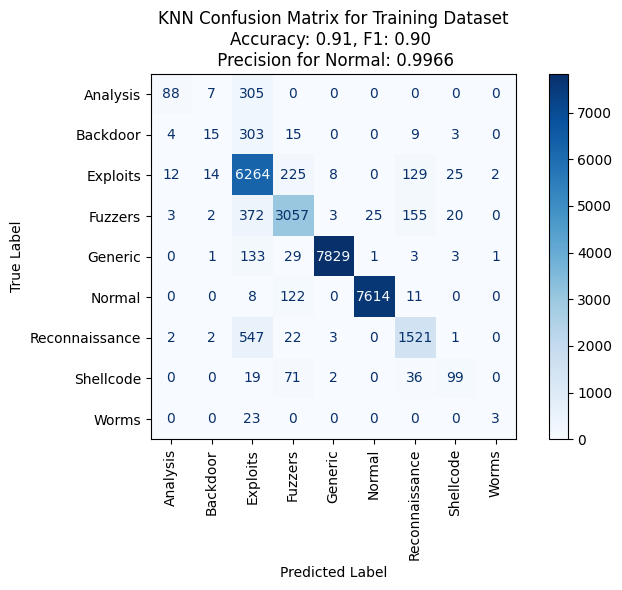

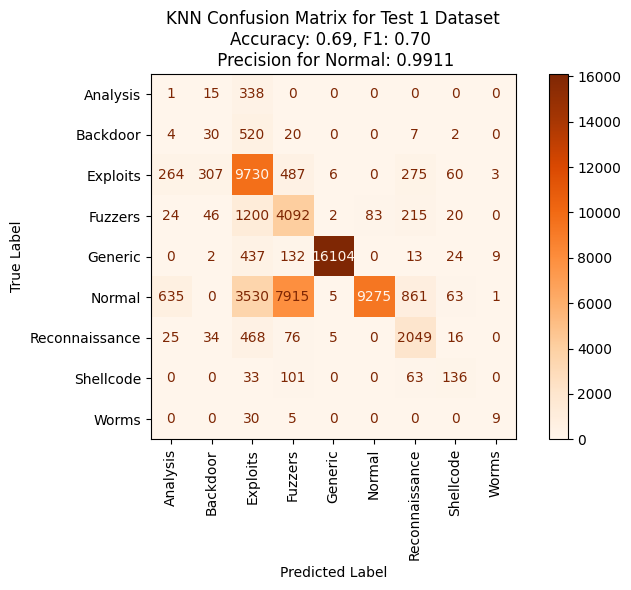

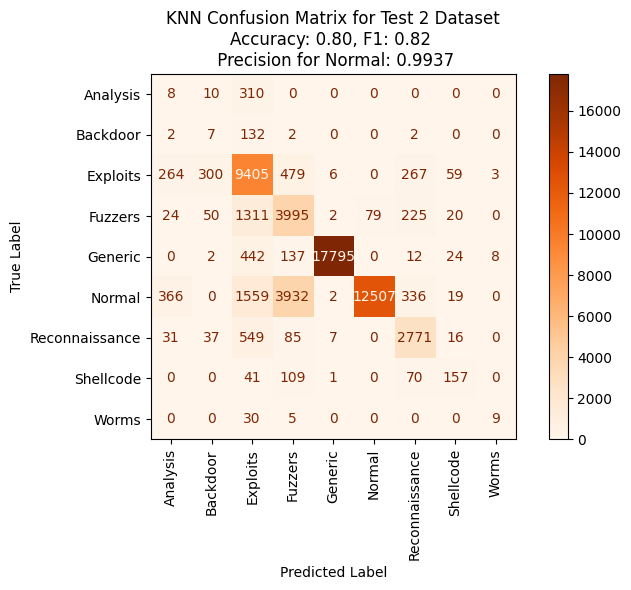

In [699]:
############ CLASSIFIERS ##############
#### k-Nearest Neighbour
hypertune = "skip" #show if want to tune hyper parameters more

# trainer

# Training Set split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) #80/20 split

# Initialize the KNN classifier and find best parameters
# knn = KNeighborsClassifier()

##### This is to reduce time now hyper parameters have been tuned!
if hypertune == "show":
    best_params = hypertune_w_CV("K-Nearest Neighbour", 'accuracy', X_train, y_train)
elif hypertune == "skip":     
    print("\n\nPre-set: K-Nearest Neighbour Best Parameters: 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 11, 'p': 1, 'weights': 'distance'")
    print("Best GridSearchCV Score: 0.9064")
    best_params = {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
    

# Train the final KNN model with the best hyperparameters on the entire training set
set_knn = KNeighborsClassifier(**best_params)
set_knn.fit(X_train, y_train)

# Cross Validate
cross_validate(set_knn, X_train, y_train, scoring='accuracy')  # this scoring also includes normal_precision custom scorer

# Make predictions on the training (X_test) set
y_train_pred = set_knn.predict(X_test)

# Evaluate the model performance
# print("\nTRAINING DATA:")
accuracy_train, F1_train, normal_precision_train = get_scores(y_test, y_train_pred, "Training", "KNN")  
KNN_Conf_train = plot_Confusion(set_knn, X_test, y_test, accuracy_train, F1_train, normal_precision_train, 'Training', "KNN")

# tester

# Predictions and accuracy for the first test set
y_test_1_pred = set_knn.predict(X_test_1)

# Evaluate the model performance
# print("\nTEST 1 DATA:")
accuracy_t1, F1_t1, normal_precision_t1 = get_scores(y_test_1, y_test_1_pred, "Test 1", "KNN")  
KNN_Conf_t1 = plot_Confusion(set_knn, X_test_1, y_test_1, accuracy_t1, F1_t1, normal_precision_t1, 'Test 1', "KNN")

# Predictions and accuracy for the second test set
y_test_2_pred = set_knn.predict(X_test_2)

# Evaluate the model performance
# print("\nTEST 2 DATA:")
accuracy_t2, F1_t2, normal_precision_t2 = get_scores(y_test_2, y_test_2_pred, "Test 2", "KNN")  
KNN_Conf_t2 = plot_Confusion(set_knn, X_test_2, y_test_2, accuracy_t2, F1_t2, normal_precision_t2, 'Test 2', "KNN")

KNN_t1_accuracyscore = accuracy_t1
KNN_t2_accuracyscore = accuracy_t2
KNN_t1_normalprecision = normal_precision_t1
KNN_t2_normalprecision = normal_precision_t2
KNN_t1_predictions = y_test_1_pred
KNN_t2_predictions = y_test_2_pred


# KNN Feature Importance Evaluation

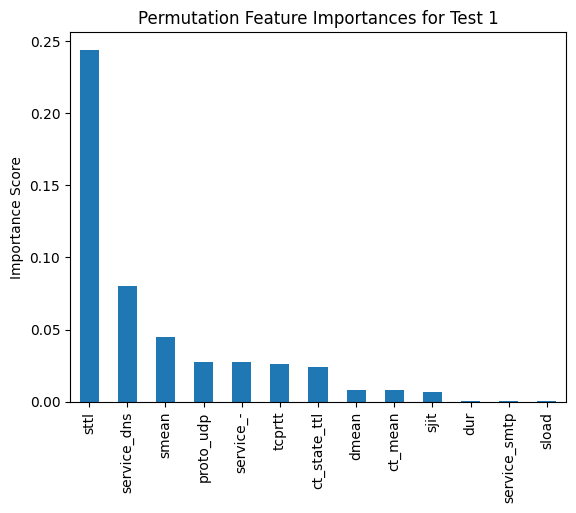

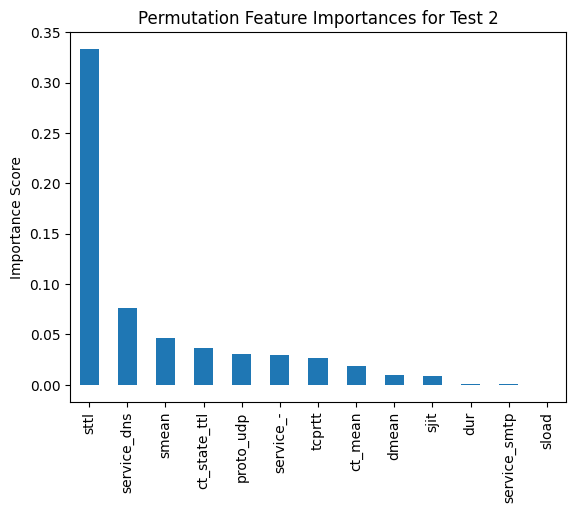

In [700]:
# permutation_feature_importance(set_knn, X_test_1, y_test_1, "Test 1")
# permutation_feature_importance(set_knn, X_test_2, y_test_2, "Test 2")

# NB: Feature Selection & Transformation

In [701]:
# Feature Selection

# #For bernoulli naive bayes - must comment out standardisation
#ALL BOOLEAN that give positive feature importance
features_df = df[['attack_cat', 'dttl_bin', 'sttl_bin', 'proto_udp', 'state_CON', 'service_dns', 'proto_arp', 'is_sm_ips_ports', 'service_-', 
'proto_ipv6', 'service_pop3', 'service_snmp', 'proto_rsvp', 'proto_cbt', 'proto_st2', 'proto_xnet', 'proto_hmp', 'proto_mux', 'proto_emcon', 
'proto_sat-mon', 'proto_iatp', 'proto_iso-ip', 'proto_tlsp', 'proto_sep', 'proto_tcf', 'proto_rvd', 'proto_pup', 'proto_sccopmce', 'proto_swipe', 
'proto_iso-tp4', 'service_dhcp', 'proto_ippc', 'proto_pim', 'proto_netblt', 'proto_sun-nd', 'proto_aes-sp3-d', 'proto_micp', 'proto_mtp', 'proto_encap', 
'proto_larp', 'proto_mobile', 'proto_irtp', 'proto_ax.25', 'proto_egp', 'proto_igmp', 'proto_ipip', 'proto_nvp', 'proto_trunk-1', 'proto_argus', 'proto_mfe-nsp', 
'service_ssl', 'proto_gre', 'proto_etherip', 'proto_igp', 'proto_visa', 'proto_sps', 'proto_srp', 'proto_leaf-2', 'service_radius', 'proto_bbn-rcc', 'proto_narp', 
'proto_ipcv', 'proto_vmtp', 'proto_mhrp'
    ]]

#for gaussian naive bayes
#14 features version
# features_df = df[['attack_cat',
#  'dur', 
#  'spkts',
#  'rate',
#  'sttl',
#  'sjit',
#  'smean',
#  'dmean',
#  'sttl_bin',
#  'dttl_bin',
#  'service_-',
#  'service_dns',
#  'service_smtp',
#  'proto_udp',
#  'proto_unas',
#     ]] 

# # Data Balance
# df_balanced = balance_w_SMOTE(features_df, target_col='attack_cat', target_size=6666)
df_balanced = features_df

# Split Sets
training_set = df_balanced
X = training_set.drop('attack_cat', axis=1)
y = training_set['attack_cat']  #for training to check type of attack

features = X.columns

X_test_1 = t1[features]
X_test_2 = t2[features]

y_test_1 = t1['attack_cat']
y_test_2 = t2['attack_cat']

#To be commented out if Bernoulli Naive Bayes
# # Standardise Training Set
# scaler = standardise_data(X)

# # Standardise Test Sets with same scaler
# standardise_test_data(X_test_1, scaler)
# standardise_test_data(X_test_2, scaler)

# Naive Bayes



Bernoulli Naive Bayes Best Parameters: {}
Best GridSearchCV Score: 0.7744
10 Fold Cross Validation: Mean of Accuracy: 0.7745
10 Fold Cross Validation: Standard Deviation of Accuracy: 0.0026
10 Fold Cross Validation: Mean of Precision score for 'Normal': 0.9958
10 Fold Cross Validation: Standard Deviation of Precision score for 'Normal': 0.0013

Naive Bayes scoring on Training set:
Accuracy: 0.77, F1 score: 0.75, Precision score for 'Normal': 0.9963
Weighted Averaged Precision: 0.8, Weighted Average Recall: 0.77

Naive Bayes scoring on Test 1 set:
Accuracy: 0.65, F1 score: 0.67, Precision score for 'Normal': 0.9925
Weighted Averaged Precision: 0.8137, Weighted Average Recall: 0.65

Naive Bayes scoring on Test 2 set:
Accuracy: 0.74, F1 score: 0.75, Precision score for 'Normal': 0.9939
Weighted Averaged Precision: 0.8283, Weighted Average Recall: 0.74


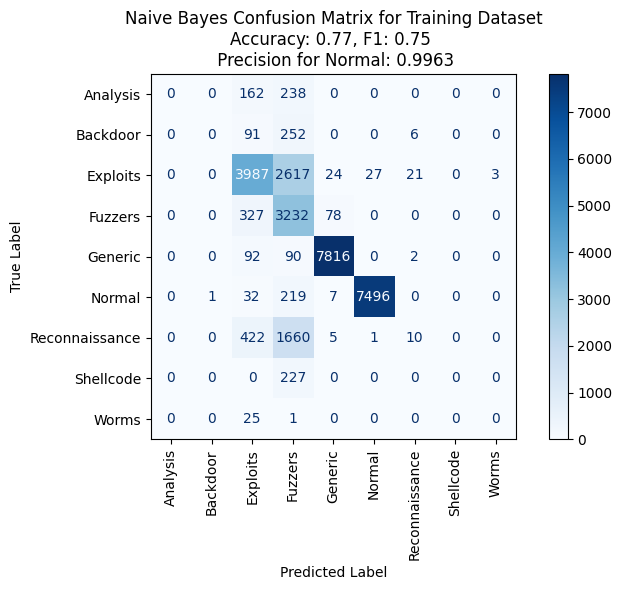

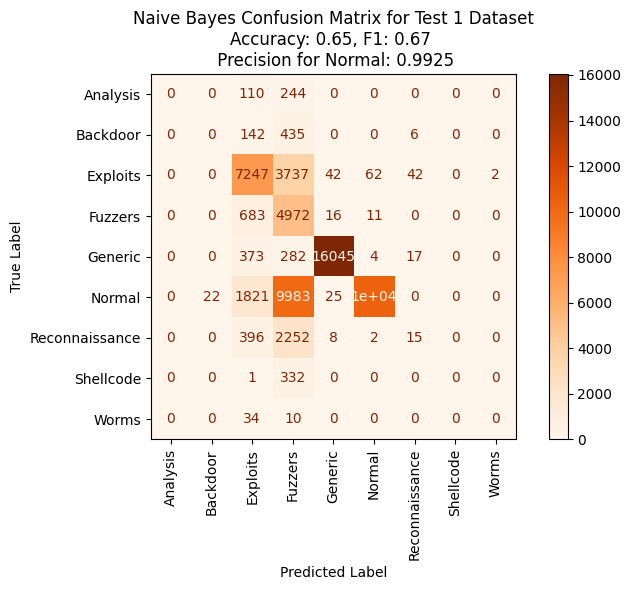

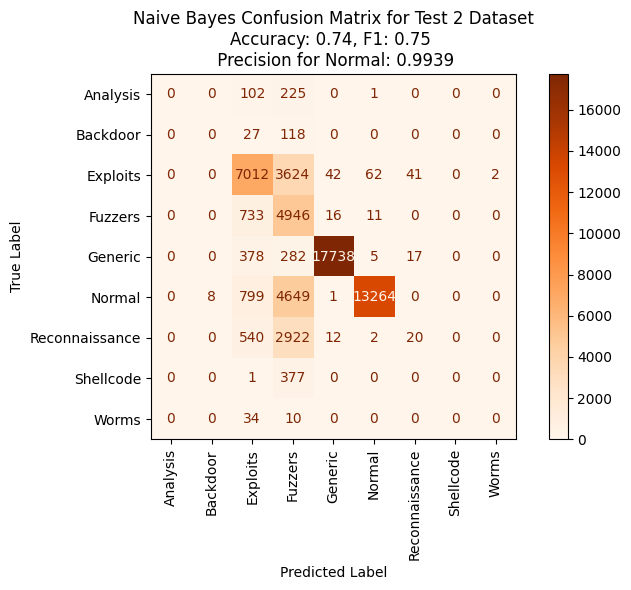

In [702]:
#### Gaussian or Bernoulli Naive Bayes

# Training Set split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) #80/20 split

# trainer

# Initialise the NB classifier and find best hyperparameters with GridSearch
# best_params = hypertune_w_CV("Gaussian Naive Bayes", 'accuracy', X_train, y_train)
best_params = hypertune_w_CV("Bernoulli Naive Bayes", 'accuracy', X_train, y_train)   #gaussian or bernoulli

# Train the final KNN model with the best hyperparameters on the entire training set
# set_nb = GaussianNB(**best_params) #gaussian or bernoulli
set_nb = BernoulliNB(**best_params) #gaussian or bernoulli
set_nb.fit(X_train, y_train)

# Cross Validate
cross_validate(set_nb, X_train, y_train, scoring='accuracy')  # this scoring also includes normal_precision custom scorer

# Make predictions on the training (X_test) set
y_train_pred = set_nb.predict(X_test)

# Evaluate the model performance
# print("\nTRAINING DATA:")
accuracy_train, F1_train, normal_precision_train = get_scores(y_test, y_train_pred, "Training", "Naive Bayes")  
NB_Conf_train = plot_Confusion(set_nb, X_test, y_test, accuracy_train, F1_train, normal_precision_train, 'Training', "Naive Bayes")
# plot_permutation_importance(set_nb, X_test, y_test, 'training')

# tester

# Predictions and accuracy for the first test set
y_test_1_pred = set_nb.predict(X_test_1)

# Evaluate the model performance
# print("\nTEST 1 DATA:")
accuracy_t1, F1_t1, normal_precision_t1 = get_scores(y_test_1, y_test_1_pred, "Test 1", "Naive Bayes")  
NB_Conf_t1 = plot_Confusion(set_nb, X_test_1, y_test_1, accuracy_t1, F1_t1, normal_precision_t1, 'Test 1', "Naive Bayes")

# Predictions and accuracy for the first test set
y_test_2_pred = set_nb.predict(X_test_2)

# Evaluate the model performance
# print("\nTEST 2 DATA:")
accuracy_t2, F1_t2, normal_precision_t2 = get_scores(y_test_2, y_test_2_pred, "Test 2", "Naive Bayes")  
NB_Conf_t2 = plot_Confusion(set_nb, X_test_2, y_test_2, accuracy_t2, F1_t2, normal_precision_t2, 'Test 2', "Naive Bayes")

NB_t1_accuracyscore = accuracy_t1
NB_t2_accuracyscore = accuracy_t2
NB_t1_normalprecision = normal_precision_t1
NB_t2_normalprecision = normal_precision_t2
NB_t1_predictions = y_test_1_pred
NB_t2_predictions = y_test_2_pred

# NB Feature Importance Evaluation

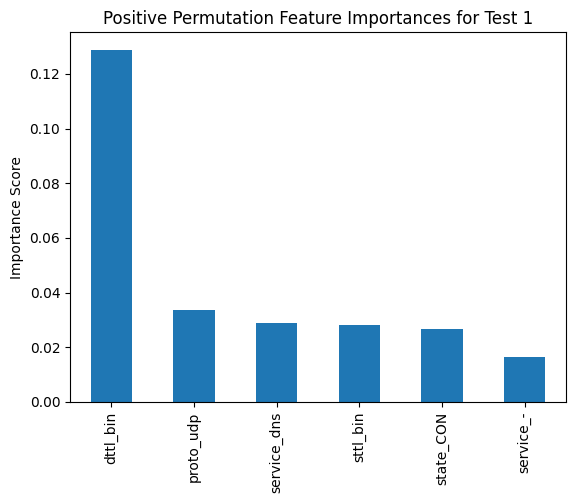

Positive features for Test 1: ['dttl_bin', 'proto_udp', 'service_dns', 'sttl_bin', 'state_CON', 'service_-']


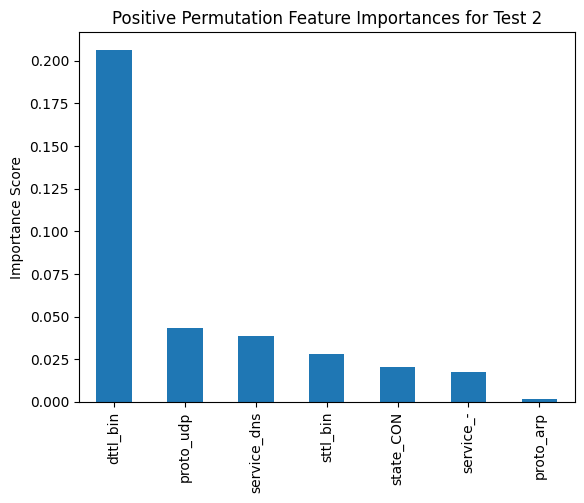

Positive features for Test 2: ['dttl_bin', 'proto_udp', 'service_dns', 'sttl_bin', 'state_CON', 'service_-', 'proto_arp']


['dttl_bin',
 'proto_udp',
 'service_dns',
 'sttl_bin',
 'state_CON',
 'service_-',
 'proto_arp']

In [703]:
# NB Feature Importance Evaluation
# permutation_feature_importance(set_nb, X_test_1, y_test_1, "Test 1")
# permutation_feature_importance(set_nb, X_test_2, y_test_2, "Test 2")

# DT: Feature Selection & Transformation

In [704]:
# Feature Selection

#10 features version 
features_df = df[['attack_cat',
 'dur', 
 'spkts',
 'rate',
 'sttl',
 'sjit',
 'smean',
 'dmean',
 'service_-',
 'service_dns',
 'proto_udp',
 'proto_swipe',
 'proto_sun-nd',
 'proto_mobile'
    ]] 

# Data Balance
# df_balanced = balance_w_SMOTE(features_df, target_col='attack_cat', target_size=6666)
df_balanced = features_df

# Split Sets
training_set = df_balanced
X = training_set.drop('attack_cat', axis=1)
y = training_set['attack_cat']  #for training to check type of attack

features = X.columns

X_test_1 = t1[features]
X_test_2 = t2[features]

y_test_1 = t1['attack_cat']
y_test_2 = t2['attack_cat']


# Standardise Training Set
scaler = standardise_data(X)

# Standardise Test Sets with same scaler
standardise_test_data(X_test_1, scaler)
standardise_test_data(X_test_2, scaler)

# Decision Trees



Pre-set: Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'best'}
Best GridSearchCV Score: 0.9117
10 Fold Cross Validation: Mean of Accuracy: 0.9125
10 Fold Cross Validation: Standard Deviation of Accuracy: 0.0024
10 Fold Cross Validation: Mean of Precision score for 'Normal': 0.9897
10 Fold Cross Validation: Standard Deviation of Precision score for 'Normal': 0.0019

Decision Tree scoring on Training set:
Accuracy: 0.91, F1 score: 0.91, Precision score for 'Normal': 0.9911
Weighted Averaged Precision: 0.9147, Weighted Average Recall: 0.91

Decision Tree scoring on Test 1 set:
Accuracy: 0.7, F1 score: 0.71, Precision score for 'Normal': 0.9788
Weighted Averaged Precision: 0.8278, Weighted Average Recall: 0.7

Decision Tree scoring on Test 2 set:
Accuracy: 0.82, F1 score: 0.83, Precision score for 'Normal': 0.9841
Weighted Averaged Precision: 0.8654, Weighted Average Recall: 0.82


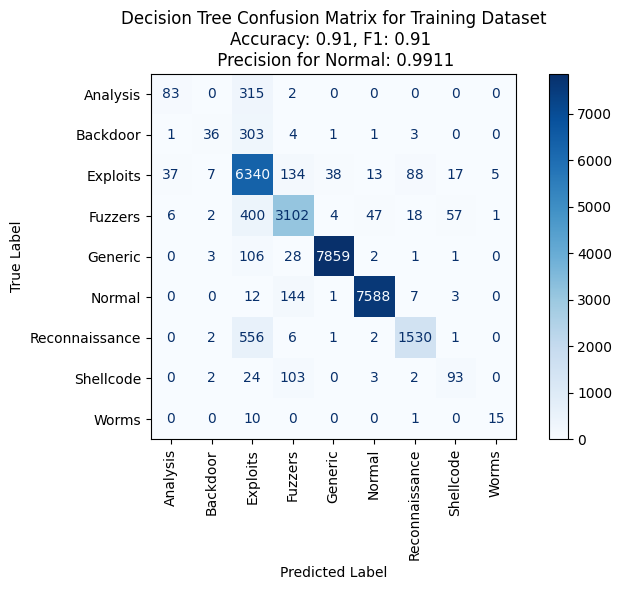

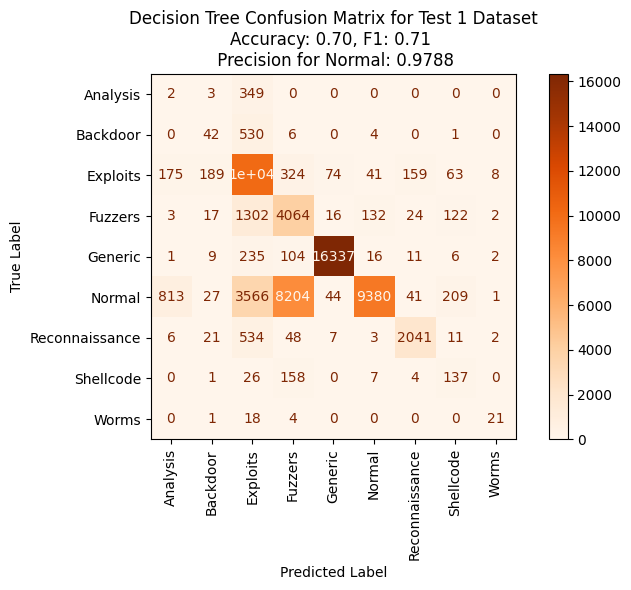

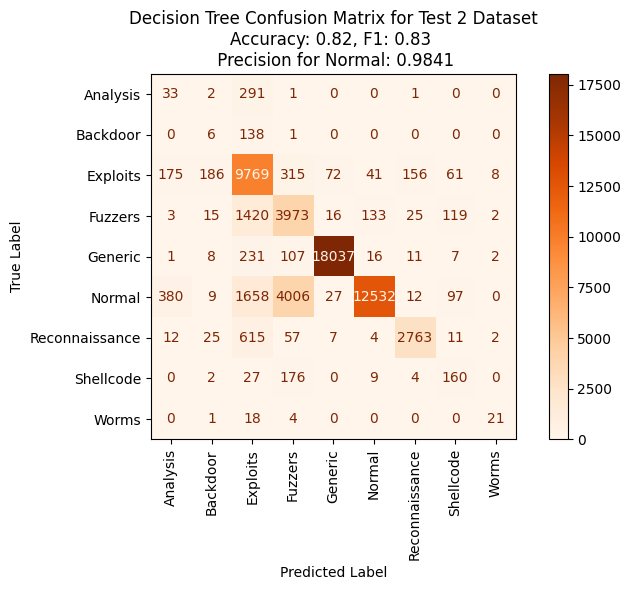

In [705]:
#### Decision Trees
hypertune = "skip" #show if want to tune hyper parameters more

# Training Set split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) #80/20 split

# trainer


##### This is to reduce time now hyper parameters have been tuned!
if hypertune == "show":
    # Initialize the DT classifier and find best parameters
    best_params = hypertune_w_CV("Decision Tree", 'accuracy', X_train, y_train)
elif hypertune == "skip":     
    print("\n\nPre-set: Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'best'}")
    print("Best GridSearchCV Score: 0.9117")
    best_params = {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'}


# Train the final DT model with the best hyperparameters on the entire training set
set_dt = DecisionTreeClassifier(**best_params)
set_dt.fit(X_train, y_train)

# Cross Validate
cross_validate(set_dt, X_train, y_train, scoring='accuracy')  # this scoring also includes normal_precision custom scorer

# Make predictions on the training (X_test) set
y_train_pred = set_dt.predict(X_test)

# Evaluate the model performance
# print("\nTRAINING DATA:")
accuracy_train, F1_train, normal_precision_train = get_scores(y_test, y_train_pred, "Training", "Decision Tree")  
DT_Conf_train = plot_Confusion(set_dt, X_test, y_test, accuracy_train, F1_train, normal_precision_train, 'Training', "Decision Tree")

# tester

# Predictions and accuracy for the first test set
y_test_1_pred = set_dt.predict(X_test_1)

# Evaluate the model performance
# print("\nTEST 1 DATA:")
accuracy_t1, F1_t1, normal_precision_t1 = get_scores(y_test_1, y_test_1_pred, "Test 1", "Decision Tree")  
DT_Conf_t1 = plot_Confusion(set_dt, X_test_1, y_test_1, accuracy_t1, F1_t1, normal_precision_t1, 'Test 1', "Decision Tree")

# Predictions and accuracy for the first test set
y_test_2_pred = set_dt.predict(X_test_2)

# Evaluate the model performance
# print("\nTEST 2 DATA:")
accuracy_t2, F1_t2, normal_precision_t2 = get_scores(y_test_2, y_test_2_pred, "Test 2", "Decision Tree")  
DT_Conf_t2 = plot_Confusion(set_dt, X_test_2, y_test_2, accuracy_t2, F1_t2, normal_precision_t2, 'Test 2', "Decision Tree")

DT_t1_accuracyscore = accuracy_t1
DT_t2_accuracyscore = accuracy_t2
DT_t1_normalprecision = normal_precision_t1
DT_t2_normalprecision = normal_precision_t2
DT_t1_predictions = y_test_1_pred
DT_t2_predictions = y_test_2_pred

# DT Feature Importance Evaluation

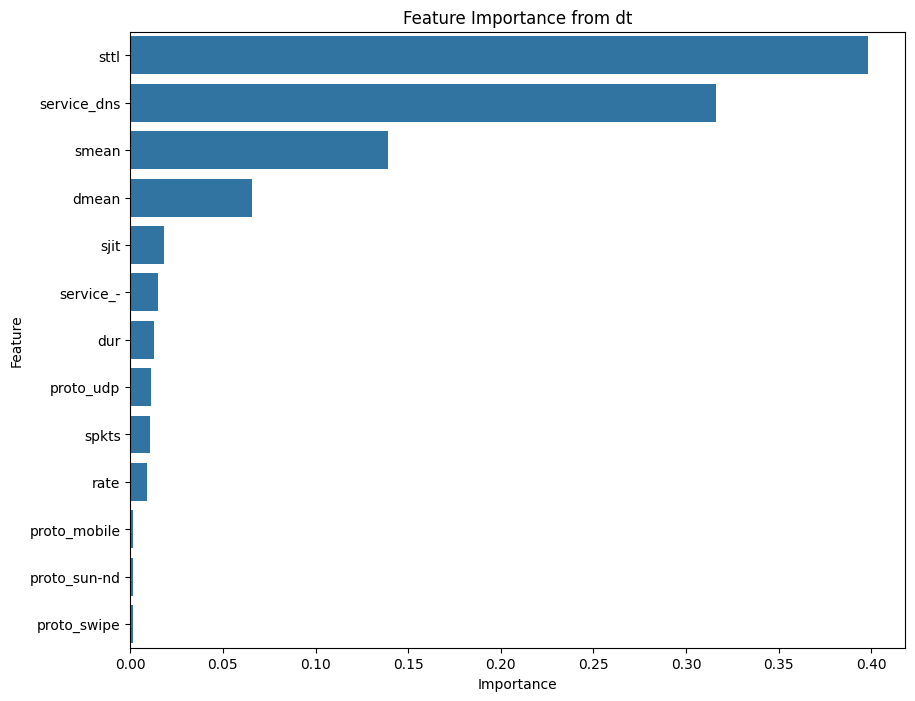

In [706]:
# #SPlits
# importances = set_dt.feature_importances_

# # Create a DataFrame for visualization
# feature_importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

# # Plotting
# plt.figure(figsize=(10, 8))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# plt.title('Feature Importance from dt')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()


# RF: Feature Selection & Transformation 

In [707]:
#14 features version
features_df = df[['attack_cat',
 'dur', 
 'spkts',
 'rate',
 'sttl',
 'sjit',
 'smean',
 'dmean',
 'sttl_bin',
 'dttl_bin',
 'service_-',
 'service_dns',
 'service_smtp',
 'proto_udp',
 'proto_unas',
    ]] 

# Data Balance
# df_balanced = balance_w_SMOTE(features_df, target_col='attack_cat', target_size=6666)
df_balanced = features_df

# Split Sets
training_set = df_balanced
X = training_set.drop('attack_cat', axis=1)
y = training_set['attack_cat']  #for training to check type of attack

features = X.columns

X_test_1 = t1[features]
X_test_2 = t2[features]

y_test_1 = t1['attack_cat']
y_test_2 = t2['attack_cat']


# Standardise Training Set
scaler = standardise_data(X)

# Standardise Test Sets with same scaler
standardise_test_data(X_test_1, scaler)
standardise_test_data(X_test_2, scaler)


# Random Forest



Pre-set: Random Forest Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 200, 'n_jobs': -1}
Best GridSearchCV Score: 0.9114
10 Fold Cross Validation: Mean of Accuracy: 0.9120
10 Fold Cross Validation: Standard Deviation of Accuracy: 0.0019
10 Fold Cross Validation: Mean of Precision score for 'Normal': 0.9992
10 Fold Cross Validation: Standard Deviation of Precision score for 'Normal': 0.0004

Random Forest scoring on Training set:
Accuracy: 0.91, F1 score: 0.9, Precision score for 'Normal': 0.9995
Weighted Averaged Precision: 0.917, Weighted Average Recall: 0.91

Random Forest scoring on Test 1 set:
Accuracy: 0.7, F1 score: 0.7, Precision score for 'Normal': 0.9992
Weighted Averaged Precision: 0.8416, Weighted Average Recall: 0.7

Random Forest scoring on Test 2 set:
Accuracy: 0.82, F1 score: 0.82, Precision score for 'Normal': 0.9995
Weighted Averaged Precision: 0.8709, Weighted Average Recall: 0.82


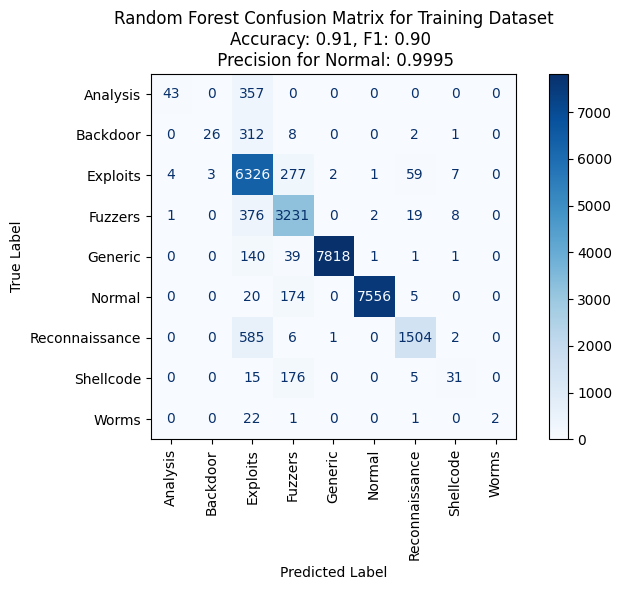

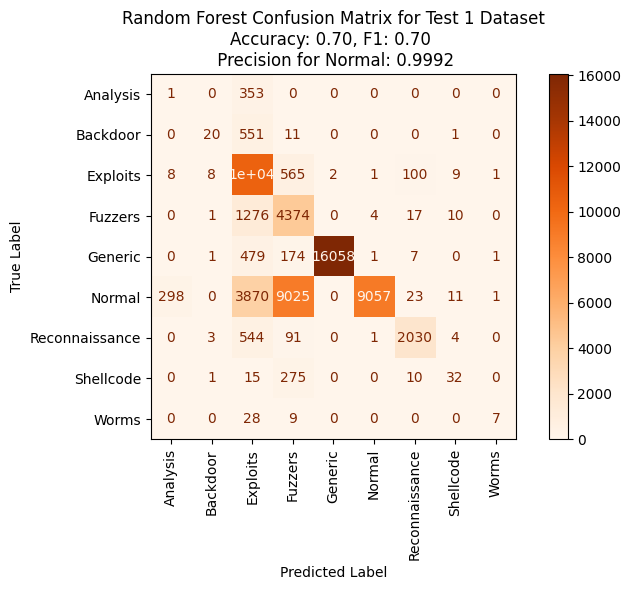

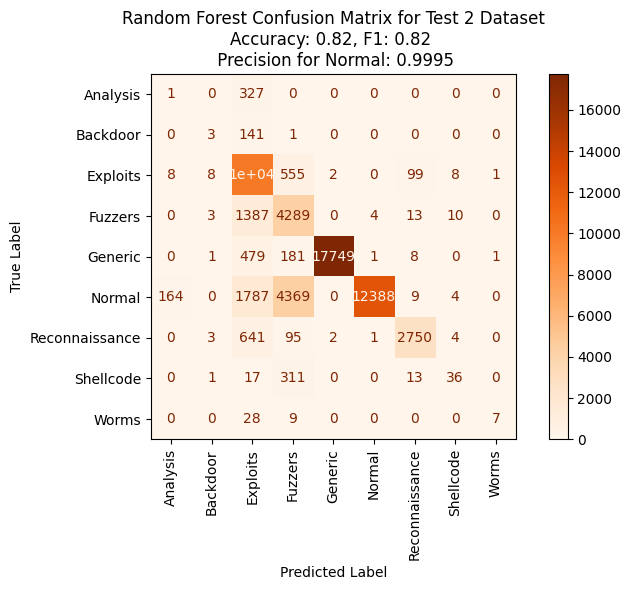

In [708]:
#### Random Forest
hypertune = "skip" #show if want to tune hyper parameters more

# Training Set split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) #80/20 split

# trainer

##### This is to reduce time now hyper parameters have been tuned!
if hypertune == "show":
    # Initialize the RF classifier and find best parameters
    best_params = hypertune_w_CV("Random Forest", 'accuracy', X_train, y_train)
elif hypertune == "skip":     
    print("\n\nPre-set: Random Forest Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 200, 'n_jobs': -1}")
    print("Best GridSearchCV Score: 0.9114")
    best_params = {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 200, 'n_jobs': -1}


# Train the final RF model with the best hyperparameters on the entire training set
set_rf = RandomForestClassifier(**best_params)
set_rf.fit(X_train, y_train)

# Cross Validate
cross_validate(set_rf, X_train, y_train, scoring='accuracy')  # this scoring also includes normal_precision custom scorer

# Make predictions on the training (X_test) set
y_train_pred = set_rf.predict(X_test)

# Evaluate the model performance
# print("\nTRAINING DATA:")
accuracy_train, F1_train, normal_precision_train = get_scores(y_test, y_train_pred, "Training", "Random Forest")  
RF_Conf_train = plot_Confusion(set_rf, X_test, y_test, accuracy_train, F1_train, normal_precision_train, 'Training', "Random Forest")

# tester

# Predictions and accuracy for the first test set
y_test_1_pred = set_rf.predict(X_test_1)

# Evaluate the model performance
# print("\nTEST 1 DATA:")
accuracy_t1, F1_t1, normal_precision_t1 = get_scores(y_test_1, y_test_1_pred, "Test 1", "Random Forest")  
RF_Conf_t1 = plot_Confusion(set_rf, X_test_1, y_test_1, accuracy_t1, F1_t1, normal_precision_t1, 'Test 1', "Random Forest")

# Predictions and accuracy for the first test set
y_test_2_pred = set_rf.predict(X_test_2)

# Evaluate the model performance
# print("\nTEST 2 DATA:")
accuracy_t2, F1_t2, normal_precision_t2 = get_scores(y_test_2, y_test_2_pred, "Test 2", "Random Forest")  
RF_Conf_t2 = plot_Confusion(set_rf, X_test_2, y_test_2, accuracy_t2, F1_t2, normal_precision_t2, 'Test 2', "Random Forest")

RF_t1_accuracyscore = accuracy_t1
RF_t2_accuracyscore = accuracy_t2
RF_t1_normalprecision = normal_precision_t1
RF_t2_normalprecision = normal_precision_t2
RF_t1_predictions = y_test_1_pred
RF_t2_predictions = y_test_2_pred

# RF: Feature Importance Evaluation

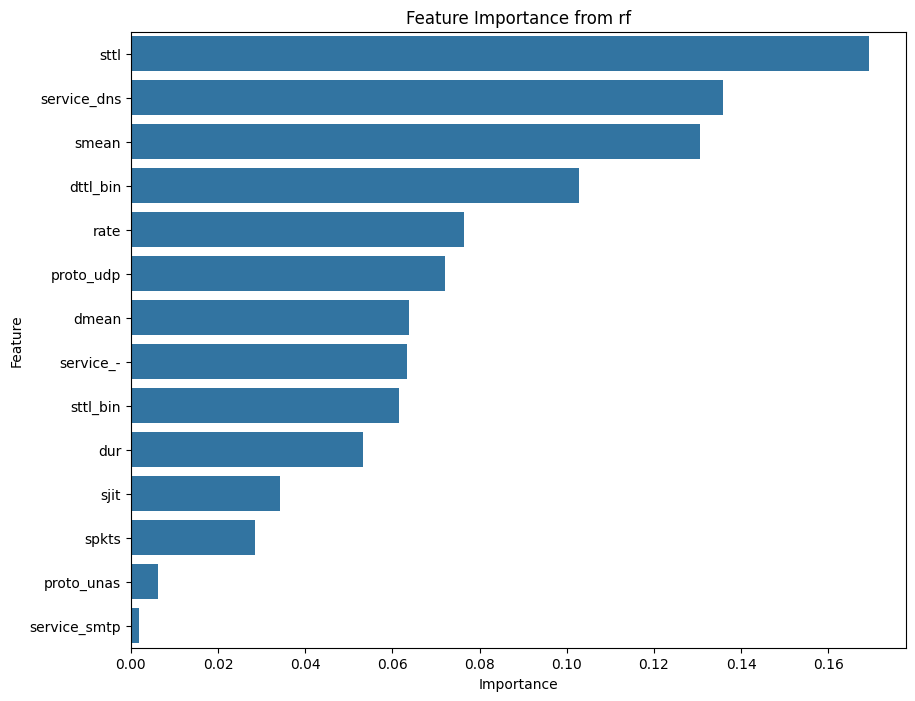

In [709]:
# #This is to see where the tree splits! Not feature importance after the test
# importances = set_rf.feature_importances_

# # Create a DataFrame for visualization
# feature_importance_rf = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

# # Plotting
# plt.figure(figsize=(10, 8))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_rf)
# plt.title('Feature Importance from rf')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

# GB: Feature Selection & Transformation

In [710]:
#8 features
features_df = df[['attack_cat', 
 'spkts',
 'sttl',
 'smean',
 'dmean',
 'dttl_bin',
 'service_-',
 'service_dns',
 'proto_udp',
    ]]        #, 'label'

# Data Balance
# df_balanced = balance_w_SMOTE(features_df, target_col='attack_cat', target_size=6666)
df_balanced = features_df

# Split Sets
training_set = df_balanced
X = training_set.drop('attack_cat', axis=1)
y = training_set['attack_cat']  #for training to check type of attack

features = X.columns

X_test_1 = t1[features]
X_test_2 = t2[features]

y_test_1 = t1['attack_cat']
y_test_2 = t2['attack_cat']


# Standardise Training Set
scaler = standardise_data(X)

# Standardise Test Sets with same scaler
standardise_test_data(X_test_1, scaler)
standardise_test_data(X_test_2, scaler)


# Gradient Boost



Pre-set: Gradient Boost Best Parameters: {'class_weight': None, 'learning_rate': 0.01, 'max_depth': 8, 'max_iter': 200}
Best GridSearchCV Score: 0.9106
10 Fold Cross Validation: Mean of Accuracy: 0.9109
10 Fold Cross Validation: Standard Deviation of Accuracy: 0.0024
10 Fold Cross Validation: Mean of Precision score for 'Normal': 0.9992
10 Fold Cross Validation: Standard Deviation of Precision score for 'Normal': 0.0001

Gradient Boost scoring on Training set:
Accuracy: 0.91, F1 score: 0.9, Precision score for 'Normal': 0.9992
Weighted Averaged Precision: 0.9112, Weighted Average Recall: 0.91

Gradient Boost scoring on Test 1 set:
Accuracy: 0.7, F1 score: 0.7, Precision score for 'Normal': 0.9973
Weighted Averaged Precision: 0.8381, Weighted Average Recall: 0.7

Gradient Boost scoring on Test 2 set:
Accuracy: 0.81, F1 score: 0.82, Precision score for 'Normal': 0.9979
Weighted Averaged Precision: 0.8681, Weighted Average Recall: 0.81


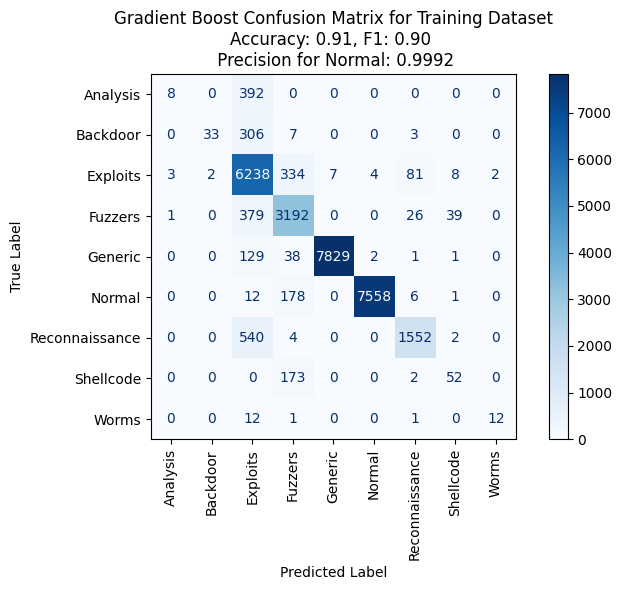

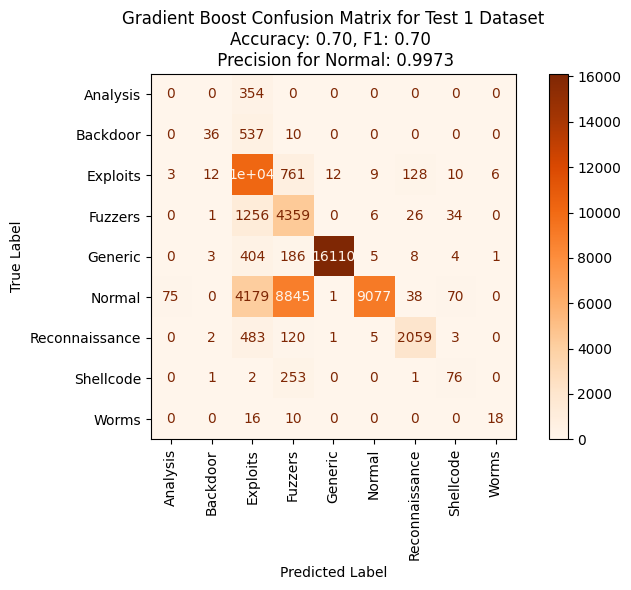

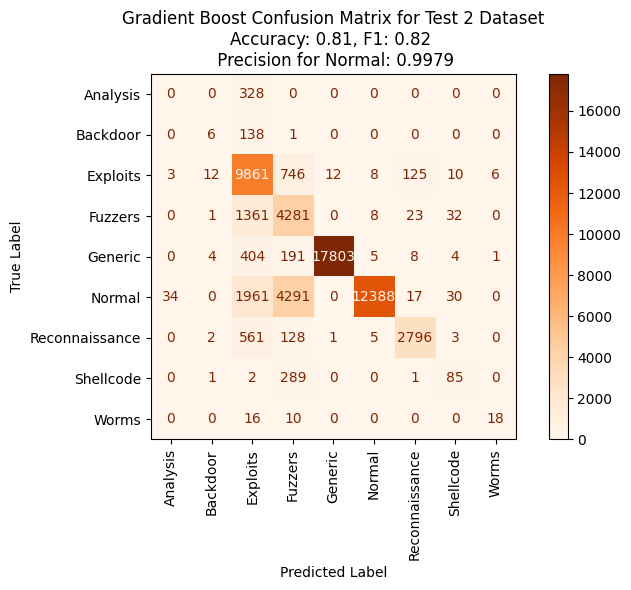

In [711]:
#### Gradient Boost
hypertune = "skip" #show if want to tune hyper parameters more

# Training Set split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) #80/20 split

# trainer

##### This is to reduce time now hyper parameters have been tuned!
if hypertune == "show":
    # Initialize the GB classifier and find best parameters
    best_params = hypertune_w_CV("Gradient Boost", 'accuracy', X_train, y_train)
elif hypertune == "skip":     
    print("\n\nPre-set: Gradient Boost Best Parameters: {'class_weight': None, 'learning_rate': 0.01, 'max_depth': 8, 'max_iter': 200}")
    print("Best GridSearchCV Score: 0.9106")
    best_params = {'class_weight': None, 'learning_rate': 0.01, 'max_depth': 8, 'max_iter': 200}



# Train the final GB model with the best hyperparameters on the entire training set
set_gb = HistGradientBoostingClassifier(**best_params)  #Histogram
set_gb.fit(X_train, y_train)

# Cross Validate
cross_validate(set_gb, X_train, y_train, scoring='accuracy')  # this scoring also includes normal_precision custom scorer

# Make predictions on the training (X_test) set
y_train_pred = set_gb.predict(X_test)

# Evaluate the model performance
# print("\nTRAINING DATA:")
accuracy_train, F1_train, normal_precision_train = get_scores(y_test, y_train_pred, "Training", "Gradient Boost")  
GB_Conf_train = plot_Confusion(set_gb, X_test, y_test, accuracy_train, F1_train, normal_precision_train, 'Training', "Gradient Boost")

# tester

# Predictions and accuracy for the first test set
y_test_1_pred = set_gb.predict(X_test_1)

# Evaluate the model performance
# print("\nTEST 1 DATA:")
accuracy_t1, F1_t1, normal_precision_t1 = get_scores(y_test_1, y_test_1_pred, "Test 1", "Gradient Boost")  
GB_Conf_t1 = plot_Confusion(set_gb, X_test_1, y_test_1, accuracy_t1, F1_t1, normal_precision_t1, 'Test 1', "Gradient Boost")

# Predictions and accuracy for the first test set
y_test_2_pred = set_gb.predict(X_test_2)

# Evaluate the model performance
# print("\nTEST 2 DATA:")
accuracy_t2, F1_t2, normal_precision_t2 = get_scores(y_test_2, y_test_2_pred, "Test 2", "Gradient Boost")  
GB_Conf_t2 = plot_Confusion(set_gb, X_test_2, y_test_2, accuracy_t2, F1_t2, normal_precision_t2, 'Test 2', "Gradient Boost")

GB_t1_accuracyscore = accuracy_t1
GB_t2_accuracyscore = accuracy_t2
GB_t1_normalprecision = normal_precision_t1
GB_t2_normalprecision = normal_precision_t2
GB_t1_predictions = y_test_1_pred
GB_t2_predictions = y_test_2_pred

# GB Feature Importance Evaluation

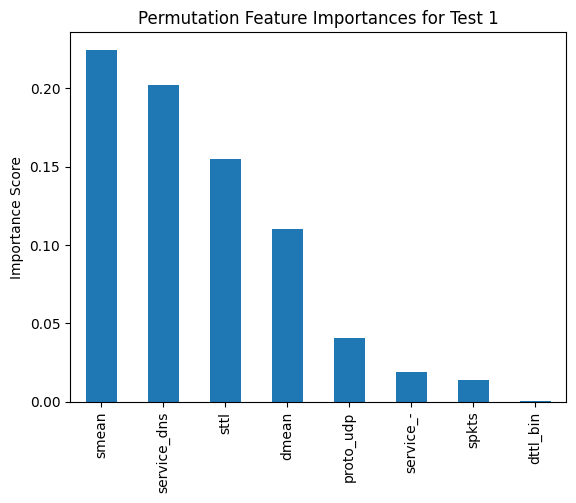

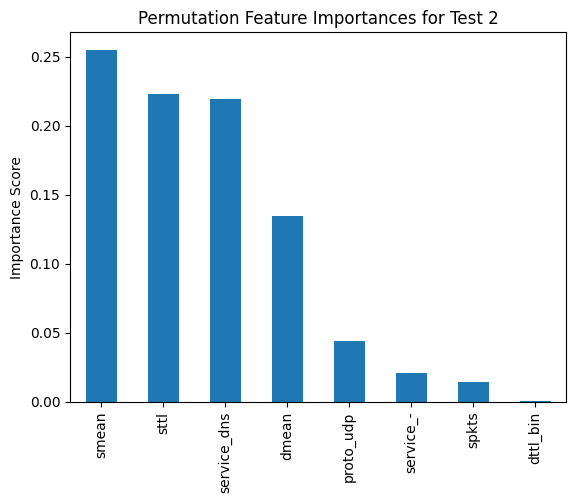

In [712]:
# GB Feature Importance Evaluation
# permutation_feature_importance(set_gb, X_test_1, y_test_1, "Test 1")
# permutation_feature_importance(set_gb, X_test_2, y_test_2, "Test 2")

# Compare & Export Best Predictors

In [713]:
#### Compare & Export Best Predictors
# Top two 'accuracy' scores for each Test Data Set

print("\n\n TOP PREDICTIONS FOR EACH TEST SET...\n")

# Accuracy scores
test1_accuracy_scores = {
    'KNN_t1': KNN_t1_accuracyscore,
    'NB_t1': NB_t1_accuracyscore,
    'DT_t1': DT_t1_accuracyscore, 
    'RF_t1': RF_t1_accuracyscore, 
    'GB_t1': GB_t1_accuracyscore
}

test2_accuracy_scores = {
    'KNN_t2': KNN_t2_accuracyscore,
    'NB_t2': NB_t2_accuracyscore,
    'DT_t2': DT_t2_accuracyscore, 
    'RF_t2': RF_t2_accuracyscore, 
    'GB_t2': GB_t2_accuracyscore
}

precision_normal = {
    'KNN_t1': KNN_t1_normalprecision,
    'KNN_t2': KNN_t2_normalprecision,
    'NB_t1': NB_t1_normalprecision,
    'NB_t2': NB_t2_normalprecision,
    'DT_t1': DT_t1_normalprecision,
    'DT_t2': DT_t2_normalprecision, 
    'RF_t1': RF_t1_normalprecision, 
    'RF_t2': RF_t2_normalprecision, 
    'GB_t1': GB_t1_normalprecision, 
    'GB_t2': GB_t2_normalprecision
}

# Confusion matrices associated with each accuracy score
confusion_matrices = {
    'KNN_t1': KNN_Conf_t1,
    'KNN_t2': KNN_Conf_t2,
    'NB_t1': NB_Conf_t1,
    'NB_t2': NB_Conf_t2,
    'DT_t1': DT_Conf_t1,
    'DT_t2': DT_Conf_t2,
    'RF_t1': RF_Conf_t1,
    'RF_t2': RF_Conf_t2, 
    'GB_t1': GB_Conf_t1,
    'GB_t2': GB_Conf_t2
}

# Predictions associated with each accuracy score
predictions = {
    'KNN_t1': KNN_t1_predictions,
    'KNN_t2': KNN_t2_predictions,
    'NB_t1': NB_t1_predictions,
    'NB_t2': NB_t2_predictions,
    'DT_t1': DT_t1_predictions,
    'DT_t2': DT_t2_predictions,
    'RF_t1': RF_t1_predictions,
    'RF_t2': RF_t2_predictions, 
    'GB_t1': GB_t1_predictions,
    'GB_t2': GB_t2_predictions
}


# Sort accuracy scores to find the top two
t1_sorted_accuracies = sorted(test1_accuracy_scores.items(), key=lambda x: x[1], reverse=True)
test1_top_two = t1_sorted_accuracies[:2]

t2_sorted_accuracies = sorted(test2_accuracy_scores.items(), key=lambda x: x[1], reverse=True)
test2_top_two = t2_sorted_accuracies[:2]

# Print the confusion matrices for the top two accuracy scores
print("\nTest Data Set 1 - Top Two Accuracy Predictions:")
for model, acc in test1_top_two:
    precision_norm_score = precision_normal.get(model, "N/A")  # Get precision score, default to "N/A" if not found
    print(f"Model: {model}, Accuracy: {acc}, Precision Score for 'Normal': {precision_norm_score}")

print("\nTest Data Set 2 - Top Two Accuracy Predictions:")
for model, acc in test2_top_two:
    precision_norm_score = precision_normal.get(model, "N/A")  # Get precision score, default to "N/A" if not found
    print(f"Model: {model}, Accuracy: {acc}, Precision Score for 'Normal': {precision_norm_score}")

# Create a DataFrame for the top two predictions
test1_top_predictions = {
    'Predict1': predictions[test1_top_two[0][0]],  # First highest
    'Predict2': predictions[test1_top_two[1][0]]  # Second highest
}

test2_top_predictions = {
    'Predict1': predictions[test2_top_two[0][0]],  # First highest
    'Predict2': predictions[test2_top_two[1][0]]  # Second highest
}

# Export to CSV
df_test1 = pd.DataFrame(test1_top_predictions)
df_test1.index = np.arange(1, len(df_test1) + 1)
df_test1.to_csv('predict_1.csv', index=True, index_label='ID')
print("\nTop two prediction sets for Test Data Set 1 have been saved to 'predict_1.csv'.")

df_test2 = pd.DataFrame(test2_top_predictions)
df_test1.index = np.arange(1, len(df_test1) + 1)
df_test2.to_csv('predict_2.csv', index=True, index_label='ID')
print("\nTop two prediction sets for Test Data Set 2 have been saved to 'predict_2.csv'.\n")



 TOP PREDICTIONS FOR EACH TEST SET...


Test Data Set 1 - Top Two Accuracy Predictions:
Model: DT_t1, Accuracy: 0.7, Precision Score for 'Normal': 0.9788
Model: RF_t1, Accuracy: 0.7, Precision Score for 'Normal': 0.9992

Test Data Set 2 - Top Two Accuracy Predictions:
Model: DT_t2, Accuracy: 0.82, Precision Score for 'Normal': 0.9841
Model: RF_t2, Accuracy: 0.82, Precision Score for 'Normal': 0.9995

Top two prediction sets for Test Data Set 1 have been saved to 'predict_1.csv'.

Top two prediction sets for Test Data Set 2 have been saved to 'predict_2.csv'.



## AdaBoost Trial

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
#14 features version
features_df = df[['attack_cat',
 'dur', 
 'spkts',
 'rate',
 'sttl',
 'sjit',
 'smean',
 'dmean',
 'sttl_bin',
 'dttl_bin',
 'service_-',
 'service_dns',
 'service_smtp',
 'proto_udp',
 'proto_unas',
    ]] 

# Data Balance
# df_balanced = balance_w_SMOTE(features_df, target_col='attack_cat', target_size=6666)
df_balanced = features_df

# Split Sets
training_set = df_balanced
X = training_set.drop('attack_cat', axis=1)
y = training_set['attack_cat']  #for training to check type of attack

features = X.columns

X_test_1 = t1[features]
X_test_2 = t2[features]

y_test_1 = t1['attack_cat']
y_test_2 = t2['attack_cat']


# Standardise Training Set
scaler = standardise_data(X)

# Standardise Test Sets with same scaler
standardise_test_data(X_test_1, scaler)
standardise_test_data(X_test_2, scaler)


Ada Boost scoring on Training set:
Accuracy: 0.33, F1 score: 0.37, Precision score for 'Normal': 0.9901
Weighted Averaged Precision: 0.5534, Weighted Average Recall: 0.33

Ada Boost scoring on Test 1 set:
Accuracy: 0.24, F1 score: 0.26, Precision score for 'Normal': 0.9953
Weighted Averaged Precision: 0.5343, Weighted Average Recall: 0.24

Ada Boost scoring on Test 2 set:
Accuracy: 0.26, F1 score: 0.3, Precision score for 'Normal': 0.997
Weighted Averaged Precision: 0.5199, Weighted Average Recall: 0.26


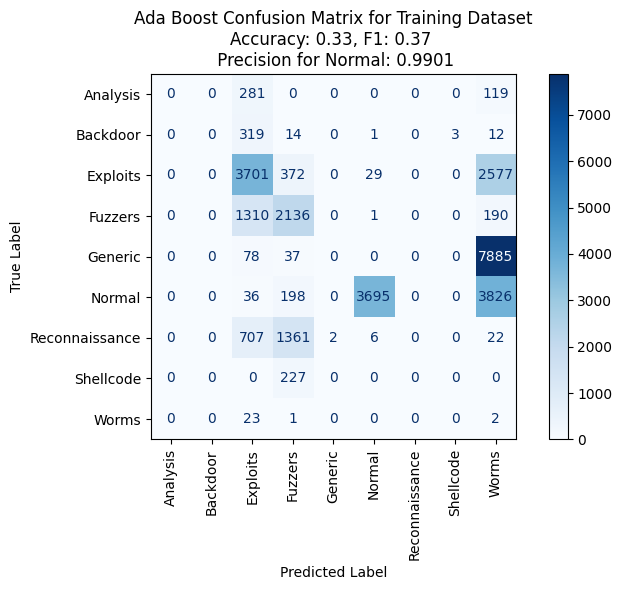

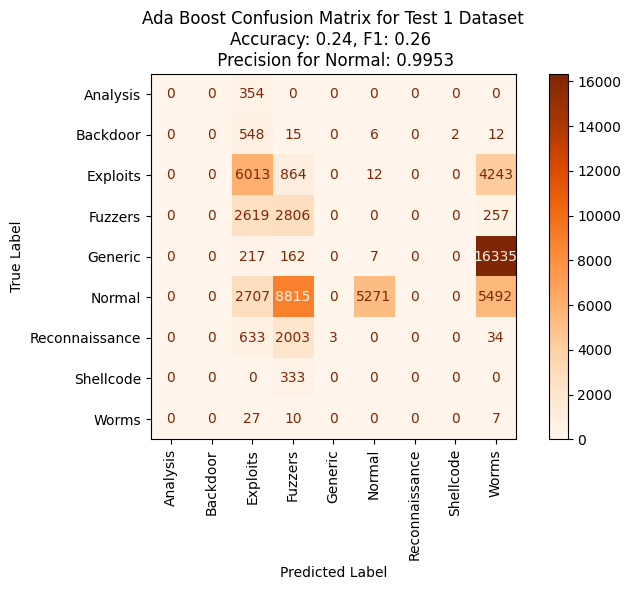

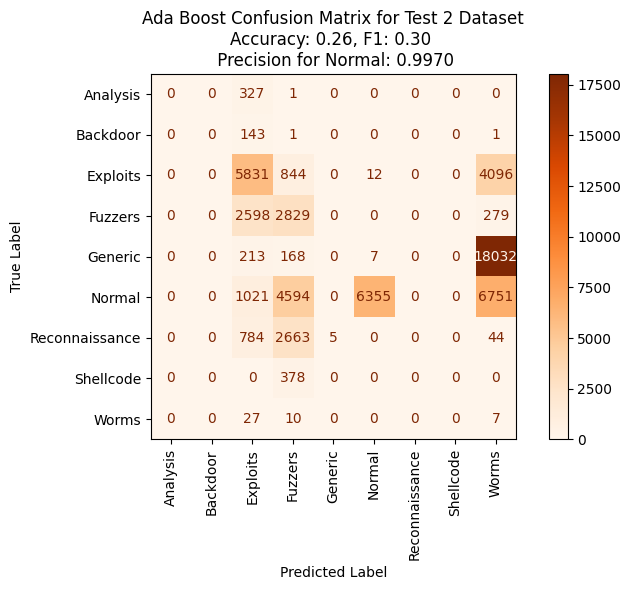

In [19]:
# AdaBoost?
hypertune = "show" #show if want to tune hyper parameters more

# Training Set split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) #80/20 split

# trainer


# ##### This is to reduce time now hyper parameters have been tuned!
if hypertune == "show":
    # Initialize the DT classifier and find best parameters
    best_params = hypertune_w_CV("Ada Boost", 'accuracy', X_train, y_train)
elif hypertune == "skip":     
    print("\n\nPre-set: Ada Boost Best Parameters: ?")
    print("Best GridSearchCV Score: 0.?")
    best_params = {}

# set_abc = AdaBoostClassifier(
#     estimator=DecisionTreeClassifier(max_depth=1),
#     n_estimators=50)



# Train the final DT model with the best hyperparameters on the entire training set
set_abc = AdaBoostClassifier(**best_params)
set_abc.fit(X_train, y_train)

# Cross Validate
# cross_validate(set_dt, X_train, y_train, scoring='accuracy')  # this scoring also includes normal_precision custom scorer

# Make predictions on the training (X_test) set
y_train_pred = set_abc.predict(X_test)

# Evaluate the model performance
# print("\nTRAINING DATA:")
accuracy_train, F1_train, normal_precision_train = get_scores(y_test, y_train_pred, "Training", "Ada Boost")  
ABC_Conf_train = plot_Confusion(set_abc, X_test, y_test, accuracy_train, F1_train, normal_precision_train, 'Training', "Ada Boost")

# tester

# Predictions and accuracy for the first test set
y_test_1_pred = set_abc.predict(X_test_1)

# Evaluate the model performance
# print("\nTEST 1 DATA:")
accuracy_t1, F1_t1, normal_precision_t1 = get_scores(y_test_1, y_test_1_pred, "Test 1", "Ada Boost")  
ABC_Conf_t1 = plot_Confusion(set_abc, X_test_1, y_test_1, accuracy_t1, F1_t1, normal_precision_t1, 'Test 1', "Ada Boost")

# Predictions and accuracy for the first test set
y_test_2_pred = set_abc.predict(X_test_2)

# Evaluate the model performance
# print("\nTEST 2 DATA:")
accuracy_t2, F1_t2, normal_precision_t2 = get_scores(y_test_2, y_test_2_pred, "Test 2", "Ada Boost")  
ABC_Conf_t2 = plot_Confusion(set_abc, X_test_2, y_test_2, accuracy_t2, F1_t2, normal_precision_t2, 'Test 2', "Ada Boost")